Multi-Driver Grand Prix Telemetry Analysis

This notebook engineers telemetry data from the Fast-F1 API for telemetry dataframes for multiple drivers. It utilizes a structured workflow for data acquisition, preparation, and further exploration prior to applying machine learning models to multi-driver behavior analysis results. Additional descriptive statistics are added to single driver data frames that will then be concatenated and used as input for machine learning models.

NOTE: This notebook will not compile as standalone. Please pull down the project from GitHub (git clone https://github.com/yourusername/f1-driving-style-analytics-tool.git) and install the necessary dependencies. Further instruction is included in the README.md

The code below adds the parent directory to Python’s module search path and configures logging to suppress all FastF1 logs below the warning level. This will enable subsequent code blocks that use imports to work seamlessly and keep my resulting code compilations clean and easy to read.

In [1]:
import sys
import os
import logging

root = os.path.abspath("..")
sys.path.append(root)

logging.getLogger('fastf1').setLevel(logging.ERROR)

In this section, I import Python libraries for data visualization, numerical analysis, and working with the Pandas dataframes that the FastF1 API is primarily structured with. I also import custom functions and modules for preprocessing F1 data and constants. To support full visibility into the datasets without truncation, I configure Pandas display options to show all rows and columns.

In [2]:
from src.data import f1_data
from src.utils import f1_constants, f1_pandas_helpers
from src.preprocessing import telemetry_cleaning, feature_engineering
from src.viz import plots

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)  # reset_option to compact dataframe view
pd.set_option('display.max_columns', None)


The following code initializes a single F1 race session by defining parameters such as year, location, and session type. These values are passed into the custom F1Session class (from f1_data.py), which creates a session object built on top of Fast-F1. This object provides access to race data as well as custom functions I’ve implemented.

These session parameters were chosen to best match Tier 2 controls:

- Location: Bahrain (clear, windy conditions)
- Green Flag Laps: Remove safety car and VSC distortions
- Single-compound Windows: Avoid mixed group comparisons
- Minimize Outliers: Tire age approx. 20 laps
- Traffic: Avoid slipstream bias (lead >2s ahead)
- Corner Analysis → Isolates driver techniques

In [3]:
year = 2025
grand_prix = f1_constants.F1Constants.LOCATIONS["Bahrain"]
session_type = f1_constants.F1Constants.SESSIONS["R"]

safety_car_laps = [32, 33, 34, 35]

session = f1_data.F1Session(year, grand_prix, session_type)

req         WARNING 	DEFAULT CACHE ENABLED! (1.03 GB) /Users/phillipsmith/Library/Caches/fastf1
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '16', '44', '1', '10', '31', '22', '87', '12', '23', '6', '7', '1

All drivers who participated in the specific location's Grand Prix will be analyzed and assigned variables to be identified by their three-letter name code.

Constants for telemetry data is also initialized as variables for ease of use during visualization.

Sector timestamps variables are set for easy replacment during telemetry filtering.

In [4]:
# driver constants
piastri = f1_constants.F1Constants.DRIVERS["Oscar Piastri"]
russell = f1_constants.F1Constants.DRIVERS["George Russell"]
norris = f1_constants.F1Constants.DRIVERS["Lando Norris"]
leclerc = f1_constants.F1Constants.DRIVERS["Charles Leclerc"]
hamilton = f1_constants.F1Constants.DRIVERS["Lewis Hamilton"]
verstappen = f1_constants.F1Constants.DRIVERS["Max Verstappen"]
gasly = f1_constants.F1Constants.DRIVERS["Pierre Gasly"]
ocon = f1_constants.F1Constants.DRIVERS["Esteban Ocon"]
tsunoda = f1_constants.F1Constants.DRIVERS["Yuki Tsunoda"]
bearman = f1_constants.F1Constants.DRIVERS["Oliver Bearman"]
antonelli = f1_constants.F1Constants.DRIVERS["Andrea Kimi Antonelli"]
albon = f1_constants.F1Constants.DRIVERS["Alexander Albon"]
hadjar = f1_constants.F1Constants.DRIVERS["Isack Hadjar"]
doohan = f1_constants.F1Constants.DRIVERS["Jack Doohan"]
alonso = f1_constants.F1Constants.DRIVERS["Fernando Alonso"]
lawson = f1_constants.F1Constants.DRIVERS["Liam Lawson"]
stroll = f1_constants.F1Constants.DRIVERS["Lance Stroll"]
bortoleto = f1_constants.F1Constants.DRIVERS["Gabriel Bortoleto"]
sainz = f1_constants.F1Constants.DRIVERS["Carlos Sainz"]
hulkenberg = f1_constants.F1Constants.DRIVERS["Nico Hulkenberg"]

# telemetry constants
speed = f1_constants.F1Constants.TELEMETRY_COLUMNS["Speed (m/s)"]
acceleration = f1_constants.F1Constants.TELEMETRY_COLUMNS["Acceleration (m/s²)"]
jerk = f1_constants.F1Constants.TELEMETRY_COLUMNS["Jerk (m/s³)"]
rpm = f1_constants.F1Constants.TELEMETRY_COLUMNS["RPM"]
g_force = f1_constants.F1Constants.TELEMETRY_COLUMNS["G-force (g)"]
gear = f1_constants.F1Constants.TELEMETRY_COLUMNS["nGear"]
throttle = f1_constants.F1Constants.TELEMETRY_COLUMNS["Throttle (%)"]
brakes = f1_constants.F1Constants.TELEMETRY_COLUMNS["BrakesApplied"]
# steering = f1_constants.F1Constants.TELEMETRY_COLUMNS["Steering Wheel Angle (°)"]

# sector timestamp variables
s1_start = 'Sector1Start'
s1_end_s2_start = 'Sector1End_Sector2Start'
s2_end_s3_start = 'Sector2End_Sector3Start'
s3_end = 'Sector3End'

The code below retrieves circuit information for the session’s corners. The `critical_turn` array identifies corners where driver behavior is especially important for sector and overall lap performance. Adjusting the `radius` value controls how much telemetry around each turn is included, allowing you to visualize throttle and braking traces at the desired level of detail.

In [5]:
corner_position = session.get_circuit_info().corners
corner_position_cleaned = telemetry_cleaning.clean_circuit_corner_data(corner_position)

critical_turn = [10]
radius = 2500

Gather, clean, and enrich each drivers' list of telemetry dataframes for their valid laps.

Each telemetry dataframe is filtered by turn to focus on the most informative segments for analyzing driver behavior and technique at brake-intensive areas.

Lando Norris Race Telemetry & Performance Metrics

In [ ]:
norris_laps = session.laps.pick_drivers(norris)
norris_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(norris_laps, safety_car_laps)
norris_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(norris_laps_filtered)
norris_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(norris_laps_filtered)

# clean each telemetry dataframes for valid laps
norris_telemetry_lap_cleaned_list = []
for norris_telemetry_lap in norris_telemetry:
    norris_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(norris_telemetry_lap, norris)
    norris_telemetry_lap_cleaned_list.append(norris_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for norris_telemetry_lap_cleaned in norris_telemetry_lap_cleaned_list:
    if norris_telemetry_lap_cleaned['LapNumber'].iloc[0] in norris_sector_timestamps_dict.keys():
        lap_number = norris_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = norris_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = norris_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        norris_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
norris_performance_metrics_df = pd.DataFrame(performance_metrics_list)

norris_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=norris,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
norris_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
norris_final_feature_df = pd.concat([norris_eda_summary_df, norris_performance_metrics_df.reset_index(drop=True)], axis=1)

,Driver,Turn,RowCount,MaxSpeed,MeanSpeed,MedianSpeed,SDSpeed,MaxAccel,MeanAccel,MedianAccel,SDAccel,MaxGs,MeanGs,MedianGs,SDGs,GearShifts,ThrottleEvents,MeanThrottle,SDThrottle,BrakeEvents,InitialBrakeTime,BrakeDuration,ThrottleRampTime,SpeedMin,ExitSpeed,ExitAccelDuration,TurnDuration
0,NOR,10,98,67.500054,44.367428,45.754897,17.748605,15.873052,1.234260,3.968299,9.819282,2.023291,0.881407,0.829532,0.483419,9,2,52.670407,45.035697,1,2.482,3.720,2.719,18.055570,67.500054,5.439,12.082
1,NOR,10,92,68.041720,44.976066,47.050038,17.675422,13.888900,1.286986,5.381947,9.683591,2.023248,0.857627,0.831667,0.498864,8,2,54.125387,44.752944,1,2.521,3.519,3.123,18.888904,68.041720,5.598,12.118
2,NOR,10,90,66.506226,43.284327,43.189849,17.408523,15.625013,0.473236,4.620009,10.034389,2.301445,0.873648,0.791737,0.526786,9,2,50.855278,44.909949,1,2.601,3.280,3.203,18.333348,66.506226,5.416,11.817
3,NOR,10,96,67.777832,43.475038,44.390756,17.449550,19.097257,1.269623,4.166670,10.801510,2.478532,0.928394,0.882413,0.599280,9,2,52.897252,43.426396,1,2.524,3.360,3.663,17.777792,66.925558,5.777,12.141
4,NOR,10,96,66.842225,43.673340,44.027813,17.277407,14.880964,1.008712,3.819448,9.782563,2.655513,0.867637,0.796654,0.495042,9,2,53.384221,44.433539,1,2.881,3.439,3.064,18.333348,66.842225,5.457,12.057
5,NOR,10,98,67.222276,42.755409,42.557904,17.391280,13.194458,0.445361,2.893521,10.307803,3.363650,0.872858,0.806419,0.580660,9,2,52.622638,44.356610,1,2.505,3.560,3.304,18.333348,66.388942,5.600,12.025
6,NOR,10,86,67.500054,42.343544,41.666700,17.484763,15.046308,1.258495,4.629639,9.846778,2.124410,0.878658,0.711695,0.493701,8,2,54.534337,43.974696,1,3.200,2.960,3.405,18.333348,66.584255,5.855,12.175
7,NOR,10,90,67.222276,43.403613,45.534759,18.028656,15.046317,-0.017866,3.472224,11.023787,4.779924,0.802327,0.708137,0.782735,9,2,49.717153,44.395379,1,2.405,3.559,3.641,18.055570,65.555608,5.480,12.004
8,NOR,10,96,68.333388,43.686419,44.166702,17.761025,15.625023,1.254042,4.960324,10.382418,3.186616,0.914522,0.809300,0.540594,8,2,53.935052,43.256174,2,2.441,3.479,3.406,18.055570,67.646660,5.655,12.215
9,NOR,10,88,68.055610,45.678420,48.911151,17.147398,17.857157,1.838322,4.687505,9.868737,2.360456,0.859574,0.708137,0.548530,9,2,59.914829,42.363384,1,2.426,3.600,3.187,19.166682,66.666720,5.400,11.826


Lando Norris Fastest Lap Telemetry for Visualization

In [7]:
norris_fastest_lap_idx = norris_laps_filtered.loc[norris_laps_filtered['LapTime'].idxmin()]
norris_fastest_telemetry = norris_fastest_lap_idx.get_telemetry()

# Get the fastest lap number
fastest_lap_number = norris_fastest_lap_idx['LapNumber']

# Clean the telemetry for this fastest lap
norris_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    norris_fastest_telemetry,
    norris
)

# Filter the cleaned telemetry down to the sector timeframe
sector_start = norris_sector_timestamps_dict[fastest_lap_number][s1_end_s2_start]
sector_end = norris_sector_timestamps_dict[fastest_lap_number][s2_end_s3_start]

norris_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    norris_fastest_telemetry_cleaned,
    start=sector_start,
    end=sector_end,
    timestamp_col='SessionTime (s)'
)

# Filter sector telemetry points that fall within the corner radius
norris_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    norris_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# Derive features for the corner-isolated telemetry
norris_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(norris_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)


Visualizations - Multiple Drivers - This multi-axis plot can dynamically display telemetry data to reveal unique driver performance for given driver dataframes.
Limit the number of features and drivers to maintain clarity.

Plot all listed drivers' fastest lap telemetry for a given corner.

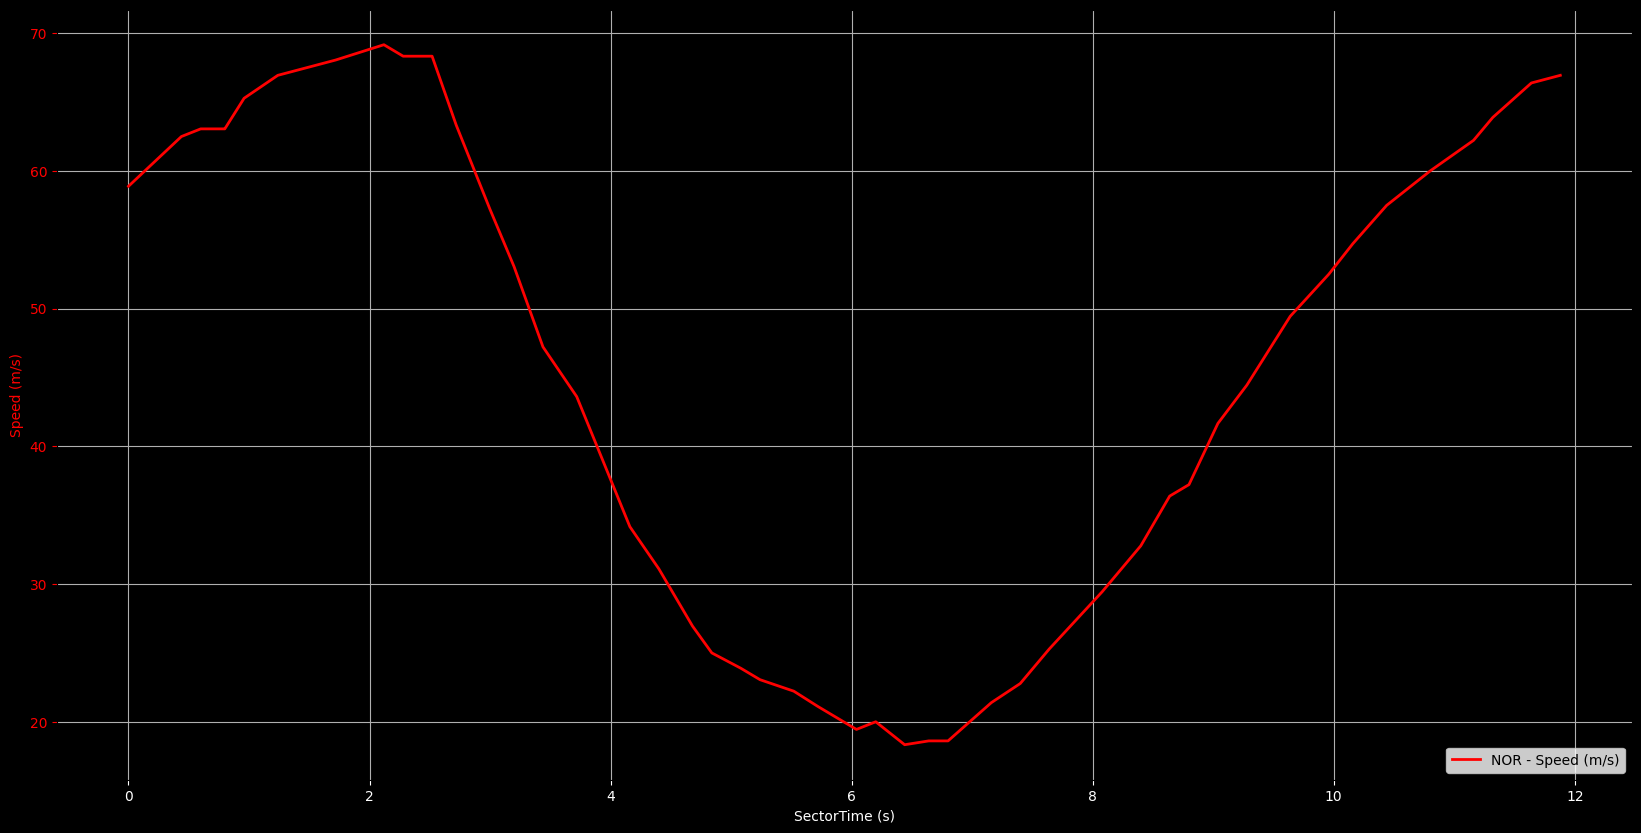

In [ ]:
plots.plot_multiple_drivers_telemetry(
    dfs=[
        norris_corner_telemetry_enriched
    ],
    drivers=[
        norris
    ],
    telemetry_cols=[speed]
)